# Explainable Diabetic Retinopathy Detection (Colab Notebook)

In [ ]:
# Required imports and set up

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from google.colab import drive
import cv2 as cv
from PIL import Image
import os
import random
import seaborn as sn
import pandas as pd

!pip install keras-tuner --upgrade

import keras_tuner as kt

drive.mount('/content/drive/', force_remount=True)

!cp -r /content/drive/MyDrive/year3/diss/3-class/ /content/



     |████████████████████████████████| 133 kB 9.2 MB/s 
Mounted at /content/drive/


In [ ]:
# GLOBAL VARIABLES (change to your requirements)

IMAGE_DIR = "/content/3-class"
BATCH_SIZE = 16
TF_EPOCHS = 5
FT_EPOCHS = 10
IMAGE_SIZE = (512,512)

METRICS = [
    'accuracy',

    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    
    tf.keras.metrics.Recall(name='recall')
  ]

## Required Functions

### Define Datasets Function

In [ ]:
# build the datasets from a directory (DIRECTORY HAS TO HAVE CORRECT STRUCTURE - check tensorflow documentation for more details)

def define_datasets(batch_size, small_training=False):

  train_ds = tf.keras.utils.image_dataset_from_directory(
      IMAGE_DIR,
      validation_split=0.3,
      label_mode='categorical',
      subset="training",
      seed=1337,
      color_mode="rgb",
      image_size=IMAGE_SIZE,
      batch_size=batch_size,
  )

  val_ds = tf.keras.utils.image_dataset_from_directory(
      IMAGE_DIR,
      validation_split=0.3,
      label_mode='categorical',
      subset="validation",
      seed=1337,
      color_mode="rgb",
      image_size=IMAGE_SIZE,
      batch_size=batch_size,
  )

  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.15)
  ])

  preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

  # reduce training data size - useful for optimizing hyper parameters
  if small_training:
    train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 3)

  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take(val_batches // 5)
  val_ds = val_ds.skip(val_batches // 5)

  train_ds = train_ds.map(
      lambda x, y: (data_augmentation(x, training=True), y)
  ) 
  train_ds = train_ds.map(
      lambda x, y: (preprocess_input(x), y)
  )

  val_ds = val_ds.map(
      lambda x, y: (preprocess_input(x), y)
  )

  test_ds = test_ds.map(
      lambda x, y: (preprocess_input(x), y)
  )

  return train_ds, val_ds, test_ds


### Explainability Functions

In [ ]:
# function to preprocess an image to run through the gradcam++ algorithm
def preprocess_data_for_grad_cam(img_path):
    img = cv.imread(img_path)
    img = crop_image_otsu(img)
    resized_img = cv.resize(img, (512, 512), interpolation=cv.INTER_LINEAR)
    cv.imwrite(img_path, resized_img)
    return resized_img


# function to crop the black background from 2-d fundus images
def crop_image_otsu(img):

    grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresholded = cv.threshold(grayscale, 0, 255, cv.THRESH_OTSU)
    bbox = cv.boundingRect(thresholded)
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground


# function that takes output of gradcam++ and overlays it over the correct part of the image
def overlap_heatmap(img_path, heatmap, alpha):
    heatmap = np.asarray(heatmap)
    img = cv.imread(img_path)
    heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = createBoxes(heatmap)

    heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")

    superimposed_img = cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)
    imgwithheat = imgwithheat.resize((256, 256), Image.BILINEAR)


    return imgwithheat


def gradCAMplusplus(model, image_path, layer_name):

    img = np.asarray(preprocess_data_for_grad_cam(image_path))
    print(img.shape)
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)  # get last conv_layer
    # modify model to let you check the last conv_layer output
    gradModel = tf.keras.Model([model.inputs], [
                               conv_layer.output, model.output])

    with tf.GradientTape() as t1:
      with tf.GradientTape() as t2:
        with tf.GradientTape() as t3:
          conv_output, preds = gradModel(img_tensor)
          class_id = np.argmax(preds[0])
          output = preds[:, class_id]
          conv_first_grad = t3.gradient(output, conv_output)
        conv_second_grad = t2.gradient(conv_first_grad, conv_output)
      conv_third_grad = t1.gradient(conv_second_grad, conv_output)

    # calculate weights for gradCAM++
    global_sum = np.sum(conv_output, axis=(0, 1, 2))
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + global_sum * conv_third_grad[0]
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)


    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
    alphas /= alpha_normalization_constant


    relu_conv = np.maximum(conv_first_grad[0], 0.0)

    weights = np.sum(alphas*relu_conv, axis=(0, 1))
    forward_activation_maps = np.sum(weights*conv_output[0], axis=2)
    cam = np.maximum(forward_activation_maps, 0.0)  # passing through RELU
    max_cam = np.max(cam)
    if max_cam == 0:
        max_cam = 1e-10
    cam /= max_cam
    cam = (cam*-1.0) + 1.0
    return cam, output


def createBoxes(heatmap):
    new_heatmap = []
    for row in heatmap:
        new_row = []
        for pixel in row:
            new_pixel = abs(pixel - 1)
            new_row.append(new_pixel)
        new_heatmap.append(new_row)
    new_heatmap = np.asarray(new_heatmap)
    heatmap = (new_heatmap*255).astype("uint8")

    _, thresh = cv.threshold(heatmap, 35, 255, cv.THRESH_BINARY_INV)

    # Find the contour of the figure
    contours, hierarchy = cv.findContours(image=thresh,
                                          mode=cv.RETR_EXTERNAL,
                                          method=cv.CHAIN_APPROX_SIMPLE)
    new_heatmap = []
    for row in heatmap:
        new_row = []
        for pixel in row:
            new_pixel = abs(pixel - 1)
            new_row.append(new_pixel)
        new_heatmap.append(new_row)
    new_heatmap = np.asarray(new_heatmap)
    heatmap = (new_heatmap*255).astype("uint8")

    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        cv.rectangle(heatmap, (x, y), (x+w, y+h), (255, 36, 15), 2)


    height, width = heatmap.shape
    mask = np.zeros((height, width), np.uint8)

    circle_img = cv.circle(mask, (256, 256), 256, (255, 255, 255), thickness=-1)
    masked_data = cv.bitwise_and(heatmap, heatmap, mask=circle_img)
    _, thresh = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)
    mask_contours, hierarcy = cv.findContours(
        thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv.boundingRect(mask_contours[0])
    crop = masked_data[y:y+h, x:x+w]


    return crop


# function to run tests on gradcam (the bad version of gradcam++)
def gradcam(model, image_path, layer_name):
    img = np.asarray(preprocess_data_for_grad_cam(image_path))
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        category_id = np.argmax(predictions[0])
        output = predictions[:, category_id]

    grads = gtape.gradient(output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    last_conv_layer_output = conv_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap

### Hyper Parameter Optimization

In [ ]:
# HyperParameter optimization for the transfer learning section

def build_model(hp):
  inputs = tf.keras.Input(shape=(512,512,3))
  base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(512,512,3), input_tensor=inputs)
  base_model.trainable = False
  target_conv_layer = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), base_model.layers))[-1].name
  conv_layer = base_model.get_layer(target_conv_layer)
  x = GlobalAveragePooling2D()(conv_layer.output)
  x = tf.keras.layers.GaussianNoise(hp.Float("gn", min_value=0.3, max_value=0.6, step=0.1))(x)
  x = Dense(units=hp.Int("units", min_value=128, max_value=512, step=32), activation="relu", kernel_regularizer="l1")(x)
  x = Dropout(hp.Float("dropout", min_value=0.1, max_value=0.6, sampling="log"))(x)
  predictions = Dense(3, activation="softmax")(x)

  model = Model(inputs=inputs, outputs=predictions)

  lr = hp.Float("lr", min_value=0.0001, max_value=0.01, sampling="log")
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[METRICS])

  return model

In [ ]:
## train model with obtained hyper-parameters for transfer learning then save to path specified in build_model_ft

inputs = tf.keras.Input(shape=(512,512,3))
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(512,512,3), input_tensor=inputs)
base_model.trainable = False
target_conv_layer = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), base_model.layers))[-1].name
conv_layer = base_model.get_layer(target_conv_layer)
x = GlobalAveragePooling2D()(conv_layer.output)
x = tf.keras.layers.GaussianNoise(0.3)(x)
x = Dense(512)(x)
x = Dropout(0.6)(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[METRICS])

model.fit(train_ds,
          validation_data = val_ds,
          epochs=10,
          callbacks=[lr_callback]) 

model.save("/content/drive/MyDrive/year3/diss/tf_model.h5")

Epoch 1/10
39/39 [==============================] - 69s 2s/step - loss: 1.4070 - accuracy: 0.3381 - auc: 0.5778 - precision: 0.4131 - recall: 0.1906 - val_loss: 1.0523 - val_accuracy: 0.3622 - val_auc: 0.6158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 56s 1s/step - loss: 1.4477 - accuracy: 0.3478 - auc: 0.5193 - precision: 0.3607 - recall: 0.2821 - val_loss: 1.0378 - val_accuracy: 0.4189 - val_auc: 0.6606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 55s 1s/step - loss: 1.4189 - accuracy: 0.3702 - auc: 0.5365 - precision: 0.3791 - recall: 0.2965 - val_loss: 1.0266 - val_accuracy: 0.4835 - val_auc: 0.7142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 56s 1s/step - loss: 1.3421 - accuracy: 0.3734 - auc: 0.5482 - precision: 0.3835 - recall: 0.2901 - val_loss: 1.0230 - val_a

In [ ]:
# HyperParameter optimization for the fine-tuning section

def build_model_ft(hp):
  model = tf.keras.models.load_model("/content/drive/MyDrive/year3/diss/tf_model.h5")
  model.trainable = True
  for layer in model.layers[:hp.Int("layers", min_value=100, max_value=300, step=50)]:
    layer.trainable = False

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Float("lr", min_value=0.0001, max_value=0.01, sampling="log")),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[METRICS])

  return model

In [ ]:
tuner = kt.BayesianOptimization(
    # change hyper model dependng on task required
    hypermodel=build_model_ft,
    objective="val_accuracy",
    max_trials = 15,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/drive/MyDrive/year3/diss/kt_ft/   " , 
    project_name="gcpp",
)

tuner.search_space_summary()
train_ds, val_ds, test_ds = define_datasets(16, small_training=True)
tuner.search(train_ds, epochs=20, validation_data=val_ds)

Trial 15 Complete [00h 25m 54s]
val_accuracy: 0.6425197124481201

Best val_accuracy So Far: 0.6818897724151611
Total elapsed time: 06h 33m 10s
INFO:tensorflow:Oracle triggered exit


## Training the model

In [ ]:
path = "/content/drive/MyDrive/year3/diss/confirmation_model/"
model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    save_weights_only=True,
    save_best_only=True
)

  
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor = 0.3,
    patience = 10,
    verbose = 1,
)


train_ds, val_ds, test_ds = define_datasets(16, small_training=True)

inputs = tf.keras.Input(shape=(512,512,3))
base_model = InceptionResNetV2(include_top = False, weights='imagenet', input_shape=(512,512,3), input_tensor=inputs)
base_model.trainable = False
target_conv_layer = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), base_model.layers))[-1].name
conv_layer = base_model.get_layer(target_conv_layer)
x = GlobalAveragePooling2D()(conv_layer.output)
x = tf.keras.layers.GaussianNoise(0.3)(x)
x = Dense(512, activation="relu", kernel_regularizer="l1")(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

lr = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [METRICS])

history = model.fit(
    train_ds, 
    epochs=TF_EPOCHS, 
    validation_data = val_ds, 
    callbacks=[model_callback, lr_callback])


base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=0.001, first_decay_steps=1500)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[METRICS])

total_epochs = TF_EPOCHS + FT_EPOCHS

history_fine = model.fit(
    train_ds, 
    validation_data = val_ds, 
    callbacks=[model_callback], 
    initial_epoch=history.epoch[-1], 
    epochs = total_epochs)

# model.save("/content/drive/MyDrive/year3/diss/dr_detection_model.h5")
# you can also save the weights if that's easier
# model.save_weights("/content/drive/MyDrive/year3/diss/models/dr_detection_model_ckpt")

model.evaluate(test_ds)

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   corrected_labels = []
   for lb in label_batch:
     corrected_labels.append(np.argmax(lb))
   y_true.append(corrected_labels)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = tf.math.confusion_matrix(correct_labels, predicted_labels, num_classes=3)
cm = np.asarray(cm)
df_cm = pd.DataFrame(cm, index = [i for i in "012"],
                    columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cbar=True)


In [ ]:
# A previously working model
model = tf.keras.models.load_model("/content/drive/MyDrive/year3/diss/model_that_works/full_model.h5")

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Produce example output with GradCAM++ heatmap overlayed

tf.Tensor([[0.5277482  0.46764198 0.00460981]], shape=(1, 3), dtype=float32)
/content/3-class/1/30334_left.jpeg : 0
(512, 512, 3)
tf.Tensor([[3.7440988e-01 6.2556839e-01 2.1799326e-05]], shape=(1, 3), dtype=float32)
/content/3-class/1/2949_right.jpeg : 1
(512, 512, 3)
tf.Tensor([[7.4495816e-01 2.5491205e-01 1.2976809e-04]], shape=(1, 3), dtype=float32)
/content/3-class/1/41688_right.jpeg : 0
(512, 512, 3)
tf.Tensor([[0.49236983 0.50010735 0.00752281]], shape=(1, 3), dtype=float32)
/content/3-class/1/30370_left.jpeg : 1
(512, 512, 3)
tf.Tensor([[0.16643593 0.65243924 0.18112478]], shape=(1, 3), dtype=float32)
/content/3-class/1/29097_left.jpeg : 1
(512, 512, 3)
tf.Tensor([[0.59166574 0.40388626 0.00444794]], shape=(1, 3), dtype=float32)
/content/3-class/1/30653_left.jpeg : 0
(512, 512, 3)
tf.Tensor([[0.7736148  0.22467354 0.00171162]], shape=(1, 3), dtype=float32)
/content/3-class/1/19815_right.jpeg : 0
(512, 512, 3)
tf.Tensor([[9.0134442e-01 9.8639481e-02 1.6165532e-05]], shape=(1, 3),

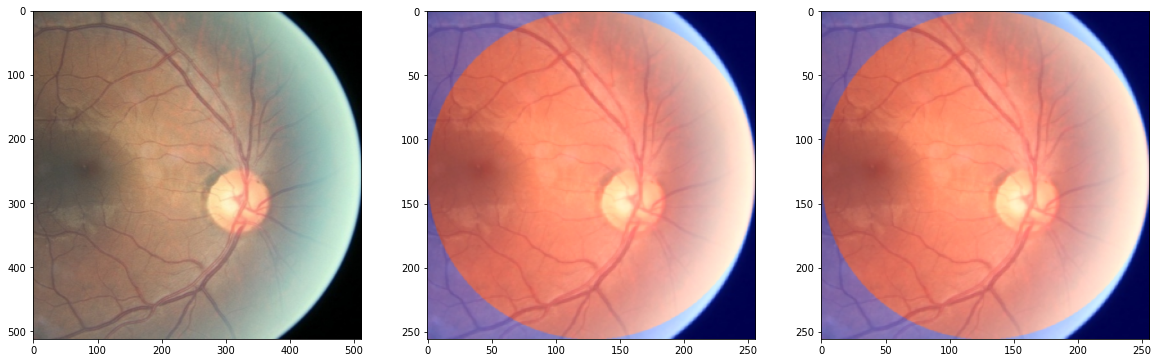

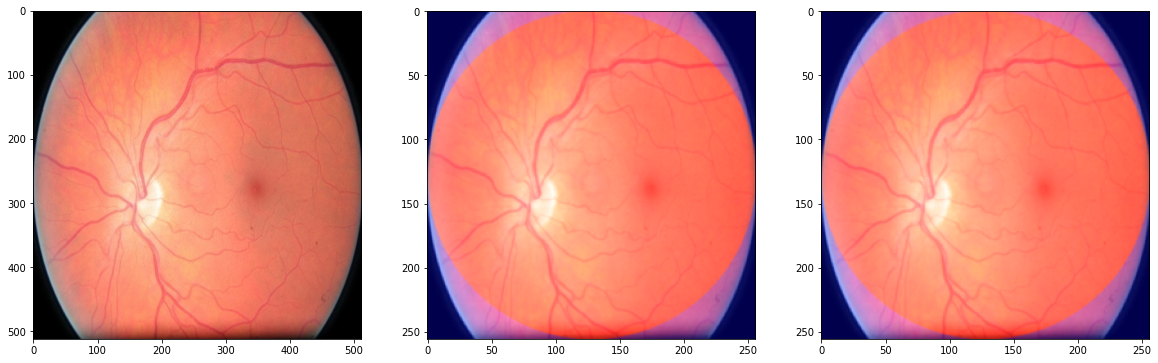

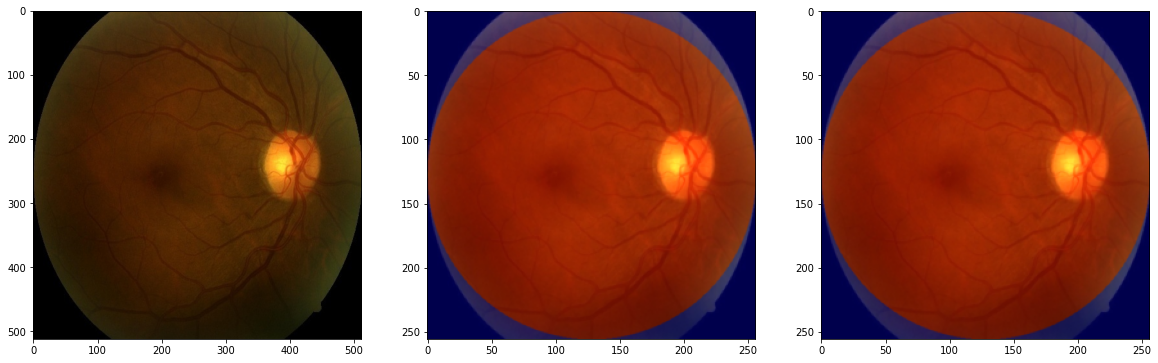

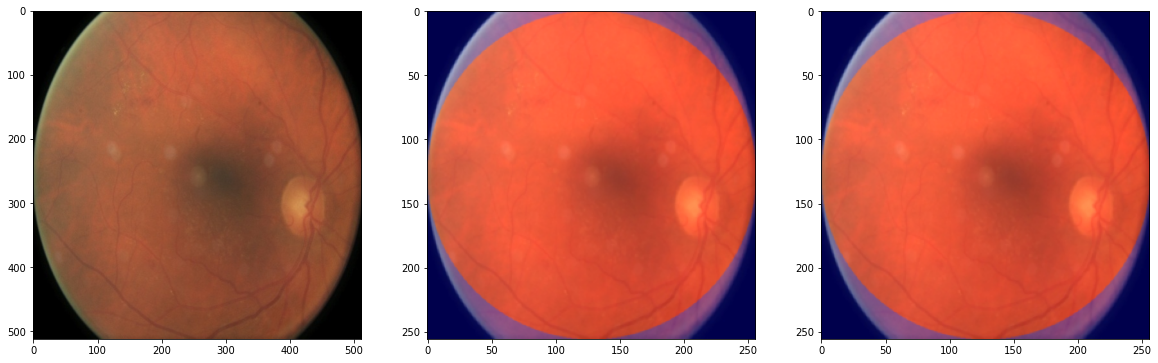

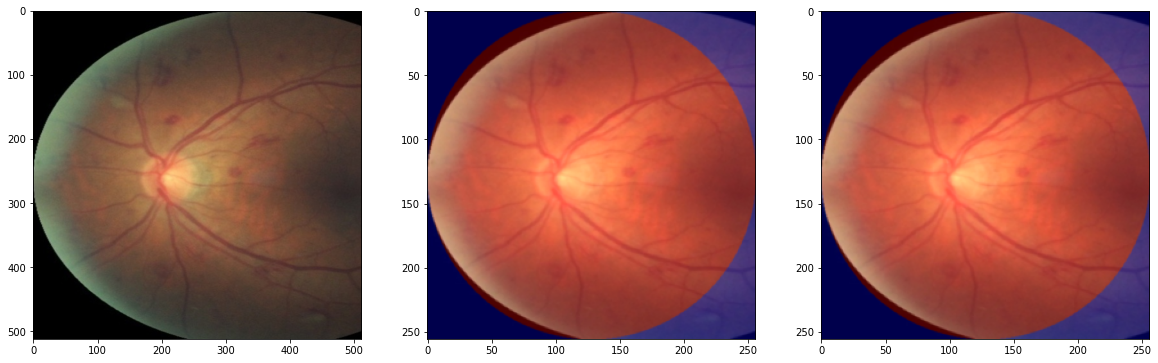

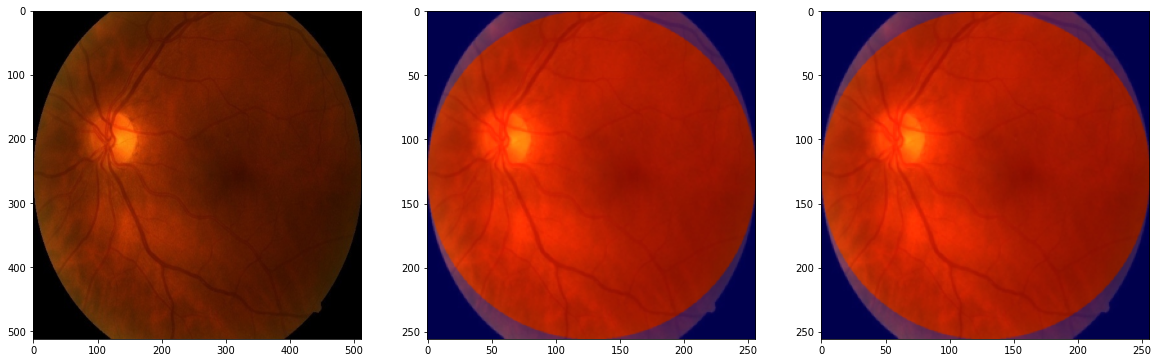

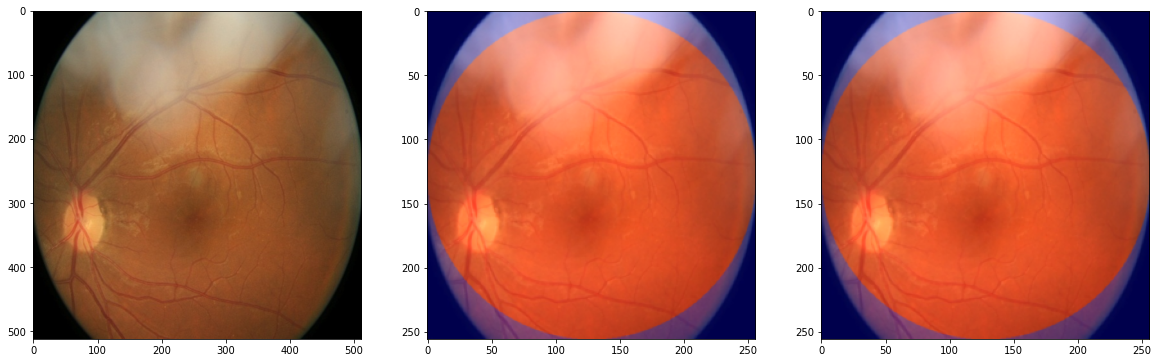

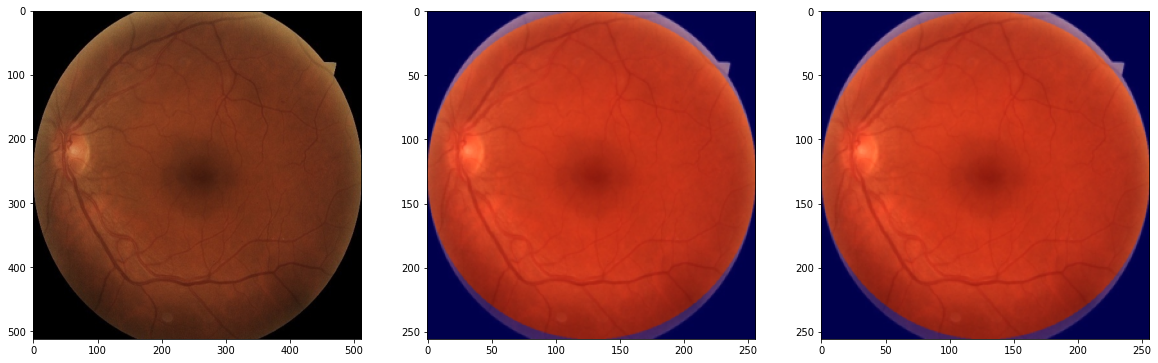

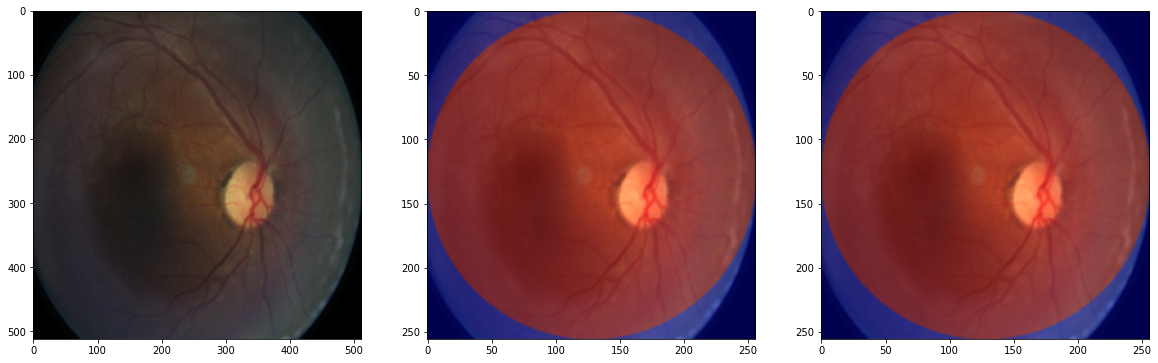

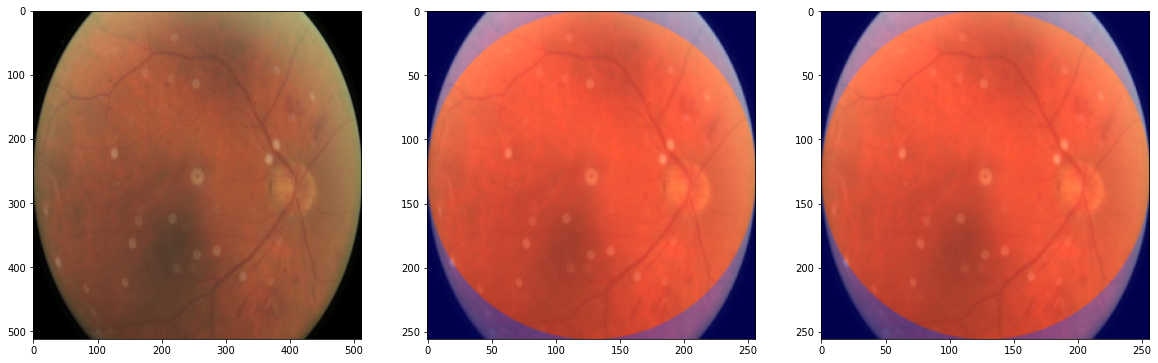

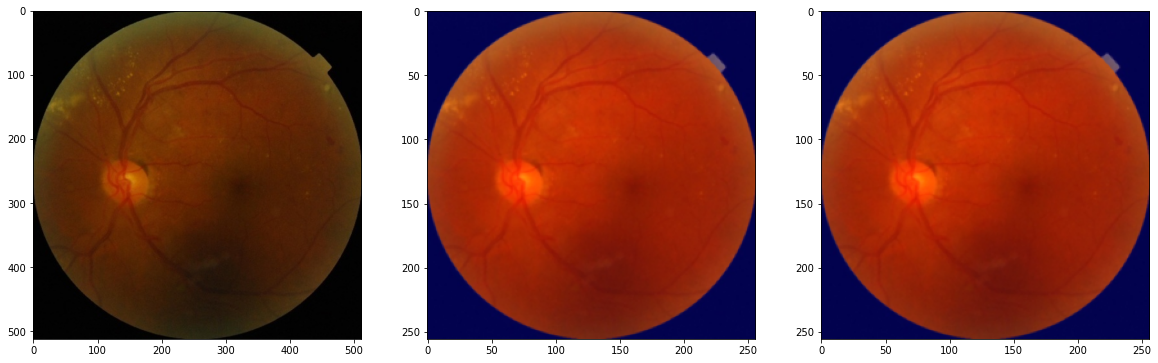

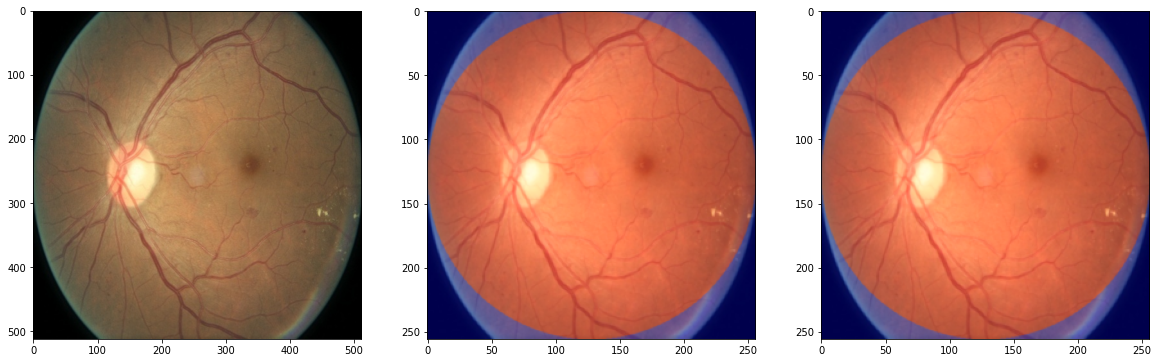

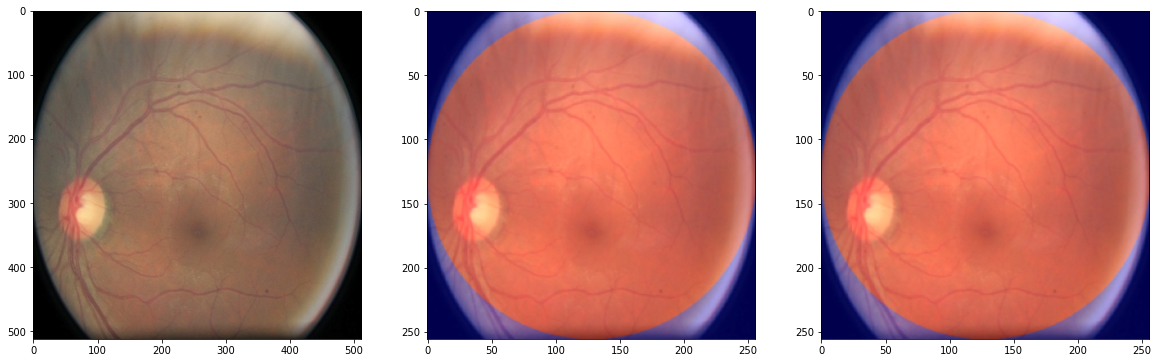

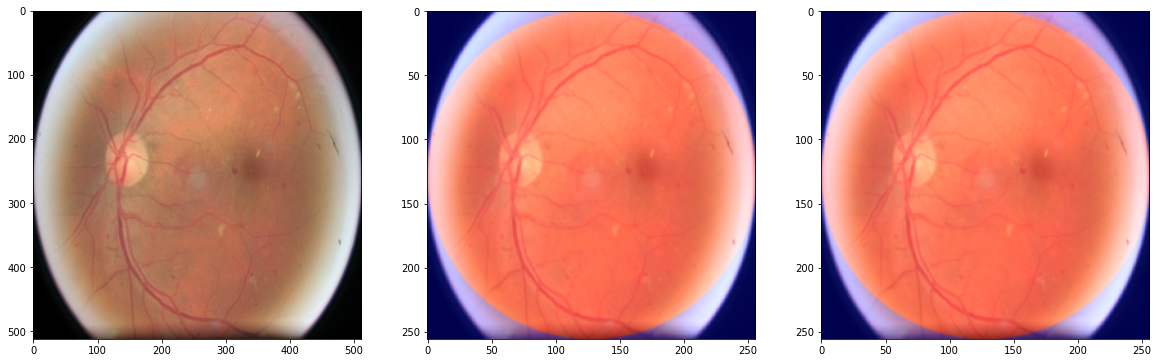

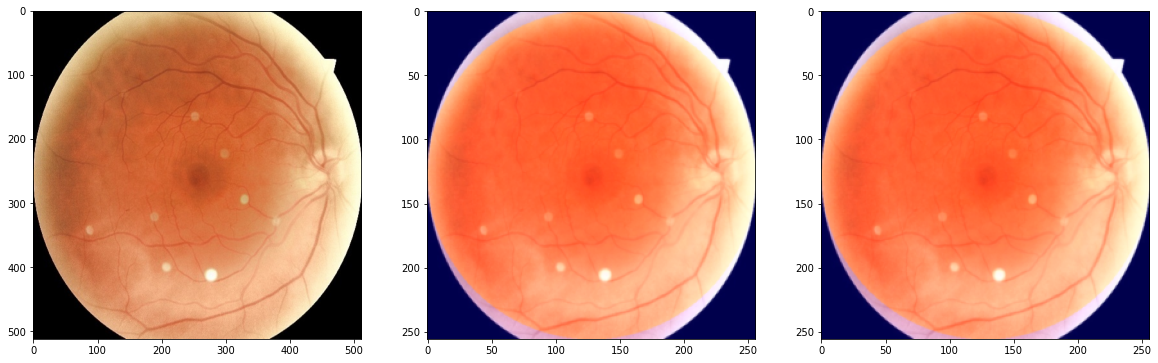

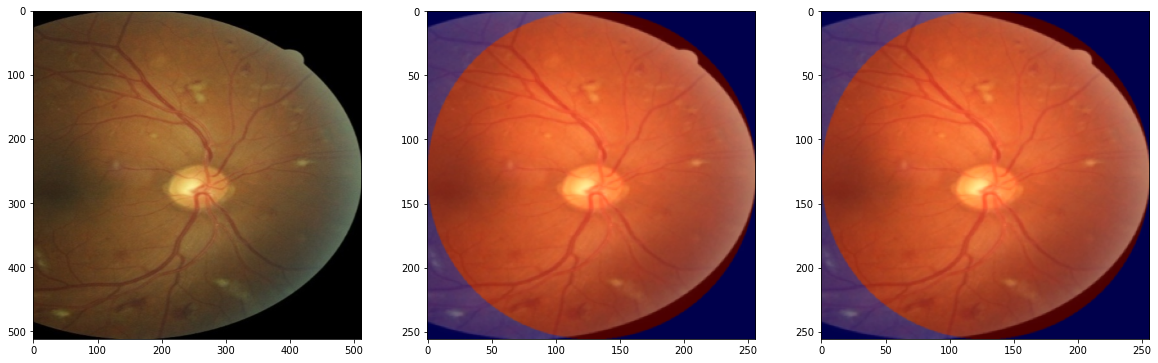

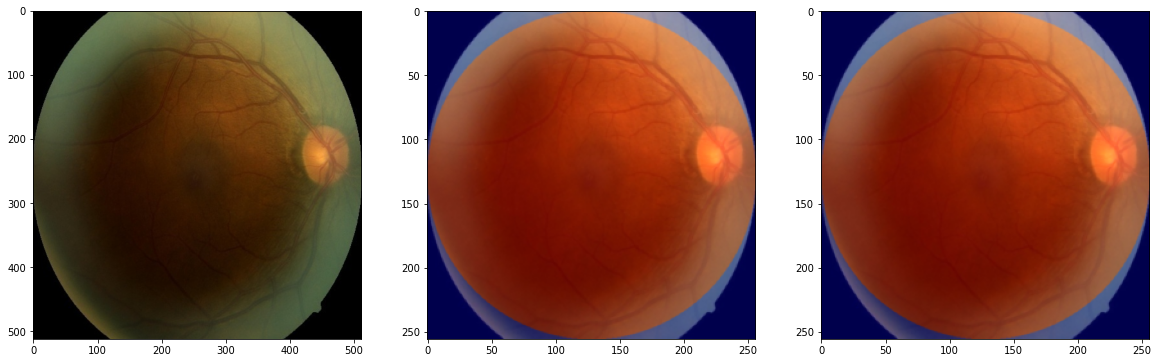

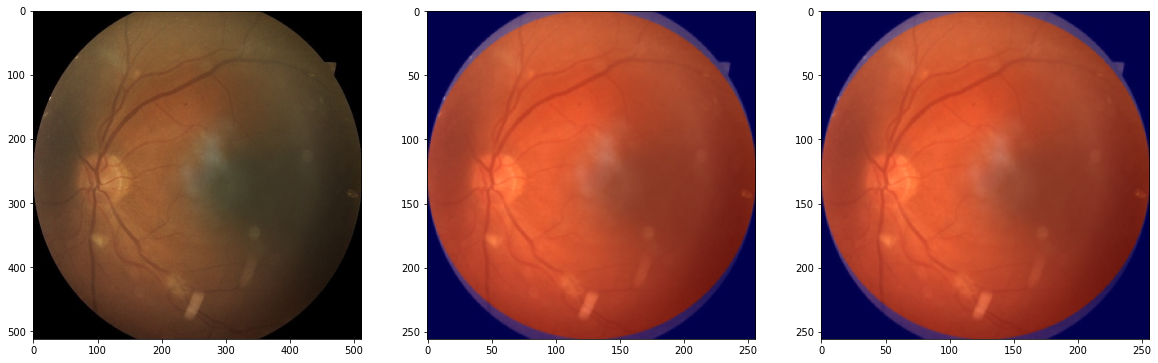

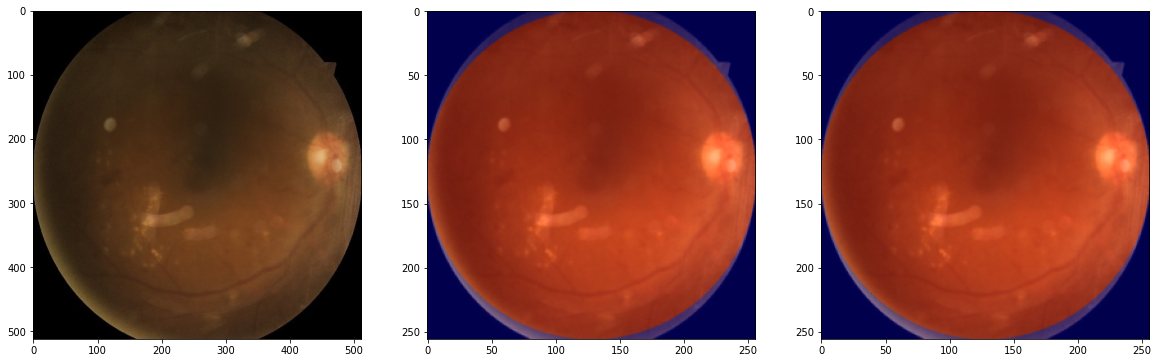

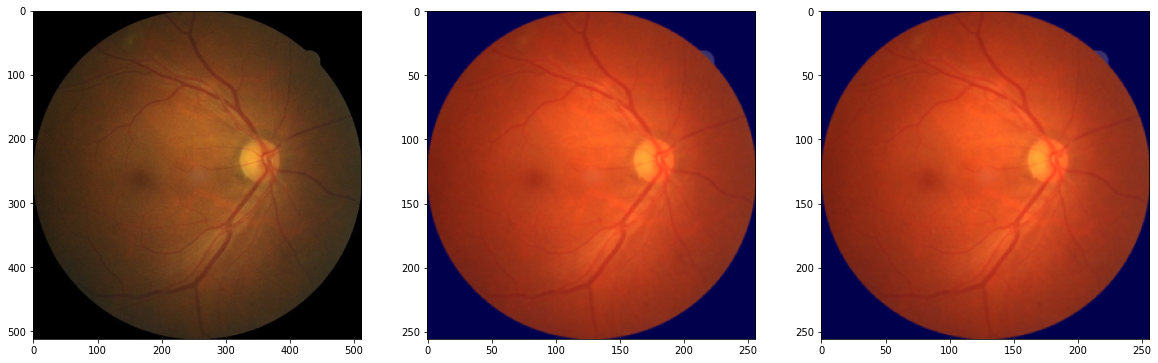

In [ ]:
images = os.listdir("/content/3-class/1/")
i = 0 
while i < 20:
  image_path = "/content/3-class/1/" + images[random.randint(0,707)]
  img = cv.imread(image_path)
  img = cv.resize(img, (512, 512), interpolation=cv.INTER_LINEAR)
  img = np.asarray(img)
  img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
  img_tensor = np.expand_dims(img, axis=0)
  preds = model(img_tensor)
  print(preds)
  class_id = np.argmax(preds[0])
  print(image_path, ":", class_id)
  # if class_id == 2:

  cam, output = gradCAMplusplus(model, image_path, 'conv_7b')
  gc = gradcam(model, image_path, 'conv_7b')
  gcppheatmap = overlap_heatmap(image_path, cam, 0.6)
  gcheatmap = overlap_heatmap(image_path, gc, 0.6)

  plt.figure(figsize=(20, 20))
  og_img = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB)
  plt.subplot(1,3,1)
  plt.imshow(og_img)
  plt.subplot(1,3,2)
  plt.imshow(gcppheatmap)
  plt.subplot(1,3,3)
  plt.imshow(gcheatmap)
  i += 1